In [5]:
import os, warnings
import numpy as np
import time


from src.data_utils import (
    load_yaml_file,
    load_data,
    split_data,
    scale_data,
    inverse_transform_data,
    save_scaler,
    save_data,
)
from src import paths
from src.vae.vae_utils import (
    instantiate_vae_model,
    train_vae,
    save_vae_model,
    get_posterior_samples,
    get_prior_samples,
    load_vae_model,
)
from src.visualize import plot_samples, plot_latent_space_samples, visualize_and_save_tsne


Epoch 1/1000


2024-11-26 03:03:16.099035: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-26 03:03:16.170894: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 8.2192 - loss: 8068.3901 - reconstruction_loss: 2686.7236 - learning_rate: 0.0010
Epoch 2/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 132.5234 - loss: 2306.0549 - reconstruction_loss: 724.5106 - learning_rate: 0.0010
Epoch 3/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 271.5968 - loss: 1047.0087 - reconstruction_loss: 258.4706 - learning_rate: 0.0010
Epoch 4/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 242.1715 - loss: 941.1547 - reconstruction_loss: 232.9944 - learning_rate: 0.0010
Epoch 5/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 178.9864 - loss: 863.3881 - reconstruction_loss: 228.1339 - learning_rate: 0.0010
Epoch 6/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 151.8020 - loss: 804.3168 - reconstruction_loss: 217.5049 - learning_rate: 0.0010
Epoch 7/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 157.7537 - loss: 784.7385 - reconstruction_loss: 208.9950 - learning_rate: 0.0

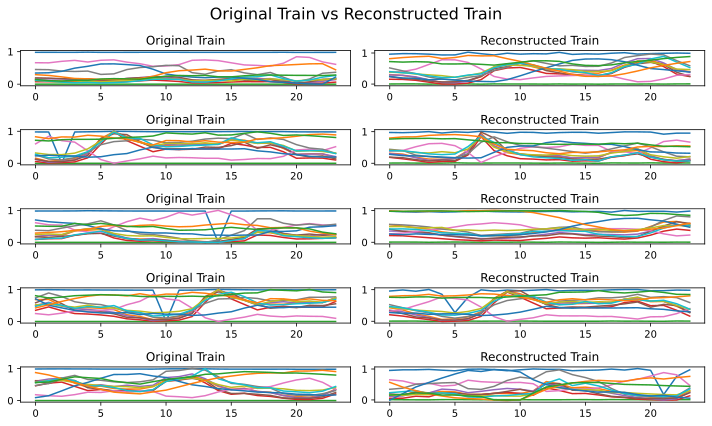

In [7]:
 # ----------------------------------------------------------------------------------
# Load data, perform train/valid split, scale data
dataset_name = "air_subsampled_train_perc_2"
vae_type = "timeVAE"


# read data
data = load_data(data_dir=paths.DATASETS_DIR, dataset=dataset_name)

# split data into train/valid splits
train_data, valid_data = split_data(data, valid_perc=0.1, shuffle=True)

# scale data
scaled_train_data, scaled_valid_data, scaler = scale_data(train_data, valid_data)

# ----------------------------------------------------------------------------------
# Instantiate and train the VAE Model

# load hyperparameters from yaml file
hyperparameters = load_yaml_file(paths.HYPERPARAMETERS_FILE_PATH)[vae_type]

# instantiate the model
_, sequence_length, feature_dim = scaled_train_data.shape
vae_model = instantiate_vae_model(
	vae_type=vae_type,
	sequence_length=sequence_length,
	feature_dim=feature_dim,
	**hyperparameters,
)

# train vae
train_vae(
	vae=vae_model,
	train_data=scaled_train_data,
	max_epochs=1000,
	verbose=1,
)

# ----------------------------------------------------------------------------------
# Save scaler and model
# model_save_dir = os.path.join(paths.MODELS_DIR, dataset_name)
# save scaler
# save_scaler(scaler=scaler, dir_path=model_save_dir)
# Save vae
# save_vae_model(vae=vae_model, dir_path=model_save_dir)

# ----------------------------------------------------------------------------------
# Visualize posterior samples
x_decoded = get_posterior_samples(vae_model, scaled_train_data)
plot_samples(
	samples1=scaled_train_data,
	samples1_name="Original Train",
	samples2=x_decoded,
	samples2_name="Reconstructed Train",
	num_samples=5,
)

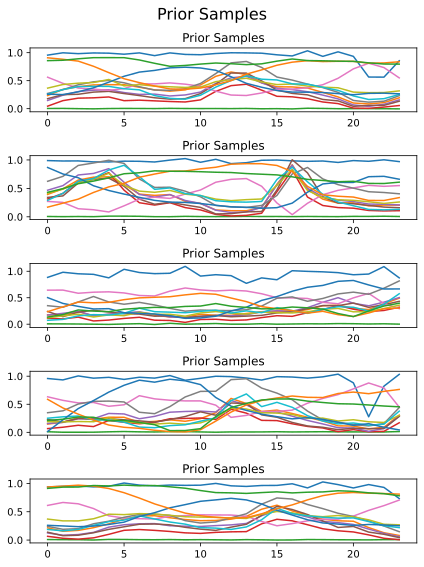

In [8]:
# Generate prior samples
prior_samples = get_prior_samples(vae_model, num_samples=train_data.shape[0])
# Plot prior samples
plot_samples(
	samples1=prior_samples,
	samples1_name="Prior Samples",
	num_samples=5,
)

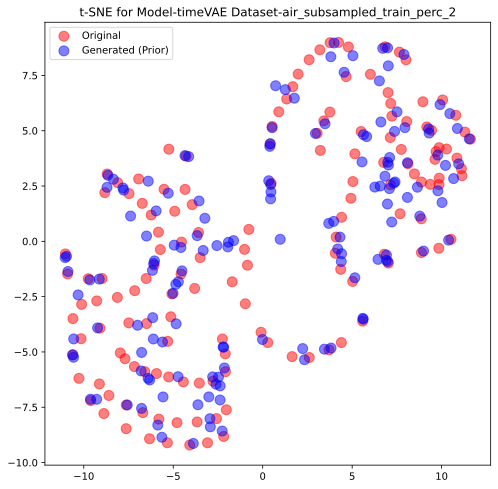

In [9]:
# visualize t-sne of original and prior samples
visualize_and_save_tsne(
	samples1=scaled_train_data,
	samples1_name="Original",
	samples2=prior_samples,
	samples2_name="Generated (Prior)",
	scenario_name=f"Model-{vae_type} Dataset-{dataset_name}",
	save_dir=os.path.join(paths.TSNE_DIR, dataset_name),
	max_samples=2000,
)